In [1]:
# Dependencies
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

from functions.load_UTKFace_data import load_UTKFace_data 
from functions.plot_results import plot_results

os.environ['CUDA_VISIBLE_DEVICES'] = '0' # which GPU is visible
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = '/tf/notebooks/data/UTKFace/UTKFace/'
OUTPUT_DIR = '/tf/notebooks/hezo/ordinal_regression/callbacks/UTKFace_bl_cnn/'

### Load data

In [3]:
X_train, train, X_valid, valid, X_test, test = load_UTKFace_data(DATA_DIR + 'UTKFace.h5')

(array([1200.,  961.,  751., 5194., 3483., 2062., 1521.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

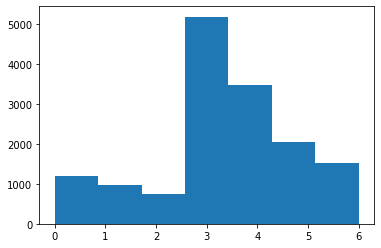

In [4]:
plt.hist(train.age_group, bins = 7)

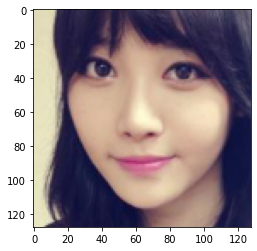

In [5]:
plt.imshow(X_train[0])

In [6]:
# One hot encoding
Y_train = to_categorical(train.age_group)
Y_valid = to_categorical(valid.age_group)
Y_test = to_categorical(test.age_group)
print(Y_train.shape, Y_valid.shape, Y_test.shape)

(15172, 7) (3792, 7) (4741, 7)


### Define a simple CNN

In [7]:
def mymodel(X):
    dropout_rate = 0.3

    in_ = keras.Input(shape = X.shape[1:])
    
    x = layers.Convolution2D(16, (3, 3), padding = 'same')(in_)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Convolution2D(16, (3, 3), padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling2D(pool_size = (2, 2))(x)
    
    x = layers.Convolution2D(32, (3, 3), padding = 'same')(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Convolution2D(32, (3, 3), padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling2D(pool_size = (2, 2))(x)
    
    x = layers.Convolution2D(32, (3, 3), padding = 'same')(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Convolution2D(32, (3, 3), padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling2D(pool_size = (2, 2))(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(500)(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(50)(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    out_ = layers.Dense(Y_train.shape[1], activation = 'softmax')(x)
    
    model = keras.Model(inputs = in_, outputs = out_)
    
    return model

In [ ]:
for i in range(5):
    
    # define model and compile
    model = mymodel(X_train)
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
    
    # define callbacks
    cp_callback = ModelCheckpoint(OUTPUT_DIR + 'without_covariables/run' + str(i) + '/model-{epoch:02d}.hdf5', 
                                  monitor = 'val_loss',
                                  verbose = 0, 
                                  save_weights_only = True,
                                  save_best_only = False, 
                                  mode = 'auto')
    
    # train
    results = model.fit(x = X_train, 
                        y = Y_train,
                        batch_size = 32,
                        epochs = 80,
                        validation_data = (X_valid, Y_valid),
                        callbacks = [cp_callback])
    
    # save results
    dat = pd.DataFrame({'train_loss': results.history['loss'], 'train_acc': results.history['accuracy'], 
                        'test_loss': results.history['val_loss'], 'test_acc': results.history['val_accuracy']})
    dat.to_csv(OUTPUT_DIR + 'without_covariables/run' + str(i) + '/history.csv', index=False)
    
    # find best model and load weights
    best_model = np.where(dat.test_loss == np.min(dat.test_loss))[0][0] +1 #+1 because indexing starts with 1 not 0
    if(best_model<10): # because keras saves as model-01 not model-1
        best_model = '0' + str(best_model)
    model.load_weights(OUTPUT_DIR + 'without_covariables/run' + str(i) + '/model-' +  str(best_model) + '.hdf5')
    
    pred = model.predict(X_test)
    out = test.join(pd.DataFrame(pred, columns = ['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'p_5', 'p_6']))
    out.to_csv(OUTPUT_DIR + 'without_covariables/run' + str(i) + '/test_predictions.csv', index=False)

Epoch 1/80
353/475 [=====================>........] - ETA: 1s - loss: 1.6991 - accuracy: 0.3479

## Add covariates

In [28]:
# to categorical
gender_ohe = to_categorical(train.gender)[:,1:] # male reference: 0 = male, 1 = female
race_ohe = to_categorical(train.race)[:,1:] # White reference: 0 = White, 1 = Black, 2 = Asian, 3 = Indian, 4 = Others (like Hispanic, Latino, Middle Eastern)
X_train_gr = np.concatenate((gender_ohe, race_ohe), axis = 1)
print(X_train_gr.shape)

(15172, 5)


In [29]:
print(train.gender[:3], train.race[:3])
print(X_train_gr[:3])

0    1
1    1
2    0
Name: gender, dtype: int64 0    2
1    3
2    2
Name: race, dtype: int64
[[1. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]


In [30]:
# to categorical
gender_ohe = to_categorical(valid.gender)[:,1:] # male reference: 0 = male, 1 = female
race_ohe = to_categorical(valid.race)[:,1:] # White reference: 0 = White, 1 = Black, 2 = Asian, 3 = Indian, 4 = Others (like Hispanic, Latino, Middle Eastern)
X_valid_gr = np.concatenate((gender_ohe, race_ohe), axis = 1)
print(X_valid_gr.shape)

(3792, 5)


In [31]:
# to categorical
gender_ohe = to_categorical(test.gender)[:,1:] # male reference: 0 = male, 1 = female
race_ohe = to_categorical(test.race)[:,1:] # White reference: 0 = White, 1 = Black, 2 = Asian, 3 = Indian, 4 = Others (like Hispanic, Latino, Middle Eastern)
X_test_gr = np.concatenate((gender_ohe, race_ohe), axis = 1)
print(X_test_gr.shape)

(4741, 5)


In [32]:
def mymodel_tab(X, X_tab):
    dropout_rate = 0.3

    x_im_in = keras.Input(shape = X.shape[1:], name = 'im_in')
    x_in = keras.Input(shape = X_tab.shape[1], name = 'x_in')
    
    x_im = layers.Convolution2D(16, (3, 3), padding = 'same')(x_im_in)
    x_im = layers.Activation('relu')(x_im)
    x_im = layers.Dropout(dropout_rate)(x_im)
    x_im = layers.Convolution2D(16, (3, 3), padding='same')(x_im)
    x_im = layers.Activation('relu')(x_im)
    x_im = layers.Dropout(dropout_rate)(x_im)
    x_im = layers.MaxPooling2D(pool_size = (2, 2))(x_im)
    
    x_im = layers.Convolution2D(32, (3, 3), padding = 'same')(x_im)
    x_im = layers.Activation('relu')(x_im)
    x_im = layers.Dropout(dropout_rate)(x_im)
    x_im = layers.Convolution2D(32, (3, 3), padding='same')(x_im)
    x_im = layers.Activation('relu')(x_im)
    x_im = layers.Dropout(dropout_rate)(x_im)
    x_im = layers.MaxPooling2D(pool_size = (2, 2))(x_im)
    
    x_im = layers.Convolution2D(32, (3, 3), padding = 'same')(x_im)
    x_im = layers.Activation('relu')(x_im)
    x_im = layers.Dropout(dropout_rate)(x_im)
    x_im = layers.Convolution2D(32, (3, 3), padding='same')(x_im)
    x_im = layers.Activation('relu')(x_im)
    x_im = layers.Dropout(dropout_rate)(x_im)
    x_im = layers.MaxPooling2D(pool_size = (2, 2))(x_im)
    x_im = layers.Flatten()(x_im)
    
    # attach the simulated data to the flattened feature vector
    x_im_x = layers.concatenate([x_im, x_in], axis = 1)
    x_im_x = layers.Dense(500)(x_im_x)
    x_im_x = layers.Activation('relu')(x_im_x)
    x_im_x = layers.Dropout(dropout_rate)(x_im_x)
    x_im_x = layers.Dense(50)(x_im_x)
    x_im_x = layers.Activation('relu')(x_im_x)
    x_im_x = layers.Dropout(dropout_rate)(x_im_x)
    x_im_x_out = layers.Dense(Y_train.shape[1], activation = 'softmax')(x_im_x)
    
    model = keras.Model(inputs = [x_im_in, x_in], outputs = x_im_x_out)
    
    return model

In [33]:
for i in range(5):
    
    # define model and compile
    model = mymodel_tab(X_train, X_train_gr)
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
    
    # define callbacks
    cp_callback = ModelCheckpoint(OUTPUT_DIR + 'with_covariables/run' + str(i) + '/model-{epoch:02d}.hdf5', 
                                  monitor = 'val_loss',
                                  verbose = 0, 
                                  save_weights_only = True,
                                  save_best_only = False, 
                                  mode = 'auto')
    
    # train
    results = model.fit(x = {'im_in': X_train, 'x_in': X_train_gr}, 
                        y = Y_train,
                        batch_size = 32,
                        epochs = 80,
                        validation_data = ({'im_in': X_valid, 'x_in': X_valid_gr}, Y_valid),
                        callbacks = [cp_callback])
    
    # save results
    dat = pd.DataFrame({'train_loss': results.history['loss'], 'train_acc': results.history['accuracy'], 
                        'test_loss': results.history['val_loss'], 'test_acc': results.history['val_accuracy']})
    dat.to_csv(OUTPUT_DIR + 'with_covariables/run' + str(i) + '/history.csv', index=False)
    
    # find best model and load weights
    best_model = np.where(dat.test_loss == np.min(dat.test_loss))[0][0] +1 #+1 because indexing starts with 1 not 0
    if(best_model<10): # because keras saves as model-01 not model-1
        best_model = '0' + str(best_model)
    model.load_weights(OUTPUT_DIR + 'with_covariables/run' + str(i) + '/model-' +  str(best_model) + '.hdf5')
    
    pred = model.predict({'im_in': X_test, 'x_in': X_test_gr})
    out = test.join(pd.DataFrame(pred, columns = ['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'p_5', 'p_6']))
    out.to_csv(OUTPUT_DIR + 'with_covariables/run' + str(i) + '/test_predictions.csv', index=False)

Epoch 1/80
475/475 [==============================] - 9s 20ms/step - loss: 1.5322 - accuracy: 0.4024 - val_loss: 1.4038 - val_accuracy: 0.4860
Epoch 2/80
475/475 [==============================] - 9s 19ms/step - loss: 1.2024 - accuracy: 0.5189 - val_loss: 1.2133 - val_accuracy: 0.5248
Epoch 3/80
475/475 [==============================] - 9s 19ms/step - loss: 1.0919 - accuracy: 0.5575 - val_loss: 1.1437 - val_accuracy: 0.5570
Epoch 4/80
475/475 [==============================] - 9s 19ms/step - loss: 1.0265 - accuracy: 0.5793 - val_loss: 1.1275 - val_accuracy: 0.5475
Epoch 5/80
475/475 [==============================] - 9s 19ms/step - loss: 0.9833 - accuracy: 0.5950 - val_loss: 1.0615 - val_accuracy: 0.5725
Epoch 6/80
475/475 [==============================] - 9s 19ms/step - loss: 0.9309 - accuracy: 0.6121 - val_loss: 1.0648 - val_accuracy: 0.5588
Epoch 7/80
475/475 [==============================] - 9s 19ms/step - loss: 0.8900 - accuracy: 0.6336 - val_loss: 1.0178 - val_accuracy: 0.5752

Epoch 58/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2046 - accuracy: 0.9290 - val_loss: 1.3636 - val_accuracy: 0.5744
Epoch 59/80
475/475 [==============================] - 9s 19ms/step - loss: 0.1861 - accuracy: 0.9372 - val_loss: 1.3075 - val_accuracy: 0.5781
Epoch 60/80
475/475 [==============================] - 9s 19ms/step - loss: 0.1867 - accuracy: 0.9328 - val_loss: 1.4110 - val_accuracy: 0.5736
Epoch 61/80
475/475 [==============================] - 9s 19ms/step - loss: 0.1972 - accuracy: 0.9323 - val_loss: 1.3258 - val_accuracy: 0.5791
Epoch 62/80
475/475 [==============================] - 9s 19ms/step - loss: 0.1865 - accuracy: 0.9339 - val_loss: 1.3530 - val_accuracy: 0.5762
Epoch 63/80
475/475 [==============================] - 9s 19ms/step - loss: 0.1793 - accuracy: 0.9372 - val_loss: 1.4206 - val_accuracy: 0.5754
Epoch 64/80
475/475 [==============================] - 9s 19ms/step - loss: 0.1816 - accuracy: 0.9357 - val_loss: 1.3673 - val_accuracy:

Epoch 35/80
475/475 [==============================] - 9s 19ms/step - loss: 0.3453 - accuracy: 0.8692 - val_loss: 1.1458 - val_accuracy: 0.5654
Epoch 36/80
475/475 [==============================] - 9s 19ms/step - loss: 0.3376 - accuracy: 0.8746 - val_loss: 1.1511 - val_accuracy: 0.5654
Epoch 37/80
475/475 [==============================] - 9s 19ms/step - loss: 0.3211 - accuracy: 0.8790 - val_loss: 1.2207 - val_accuracy: 0.5559
Epoch 38/80
475/475 [==============================] - 9s 19ms/step - loss: 0.3316 - accuracy: 0.8775 - val_loss: 1.1675 - val_accuracy: 0.5691
Epoch 39/80
475/475 [==============================] - 9s 19ms/step - loss: 0.3094 - accuracy: 0.8859 - val_loss: 1.2260 - val_accuracy: 0.5493
Epoch 40/80
475/475 [==============================] - 9s 19ms/step - loss: 0.3150 - accuracy: 0.8858 - val_loss: 1.1838 - val_accuracy: 0.5509
Epoch 41/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2947 - accuracy: 0.8933 - val_loss: 1.2599 - val_accuracy:

Epoch 12/80
475/475 [==============================] - 9s 19ms/step - loss: 0.7739 - accuracy: 0.6762 - val_loss: 1.0022 - val_accuracy: 0.5775
Epoch 13/80
475/475 [==============================] - 9s 19ms/step - loss: 0.7450 - accuracy: 0.6900 - val_loss: 0.9570 - val_accuracy: 0.6039
Epoch 14/80
475/475 [==============================] - 9s 19ms/step - loss: 0.7183 - accuracy: 0.7044 - val_loss: 0.9892 - val_accuracy: 0.5997
Epoch 15/80
475/475 [==============================] - 9s 19ms/step - loss: 0.6961 - accuracy: 0.7110 - val_loss: 0.9658 - val_accuracy: 0.5934
Epoch 16/80
475/475 [==============================] - 9s 19ms/step - loss: 0.6662 - accuracy: 0.7250 - val_loss: 0.9862 - val_accuracy: 0.6026
Epoch 17/80
475/475 [==============================] - 9s 19ms/step - loss: 0.6553 - accuracy: 0.7295 - val_loss: 0.9787 - val_accuracy: 0.5989
Epoch 18/80
475/475 [==============================] - 9s 19ms/step - loss: 0.6164 - accuracy: 0.7453 - val_loss: 0.9764 - val_accuracy:

Epoch 69/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2174 - accuracy: 0.9244 - val_loss: 1.2643 - val_accuracy: 0.5694
Epoch 70/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2042 - accuracy: 0.9251 - val_loss: 1.3608 - val_accuracy: 0.5699
Epoch 71/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2186 - accuracy: 0.9244 - val_loss: 1.3271 - val_accuracy: 0.5628
Epoch 72/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2066 - accuracy: 0.9258 - val_loss: 1.3751 - val_accuracy: 0.5738
Epoch 73/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2107 - accuracy: 0.9251 - val_loss: 1.3371 - val_accuracy: 0.5665
Epoch 74/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2166 - accuracy: 0.9266 - val_loss: 1.3262 - val_accuracy: 0.5762
Epoch 75/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2066 - accuracy: 0.9268 - val_loss: 1.3125 - val_accuracy:

Epoch 46/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2528 - accuracy: 0.9100 - val_loss: 1.1595 - val_accuracy: 0.6010
Epoch 47/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2667 - accuracy: 0.9038 - val_loss: 1.1688 - val_accuracy: 0.6018
Epoch 48/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2657 - accuracy: 0.9047 - val_loss: 1.2218 - val_accuracy: 0.5844
Epoch 49/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2586 - accuracy: 0.9049 - val_loss: 1.1689 - val_accuracy: 0.5823
Epoch 50/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2443 - accuracy: 0.9110 - val_loss: 1.1660 - val_accuracy: 0.5865
Epoch 51/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2410 - accuracy: 0.9150 - val_loss: 1.2203 - val_accuracy: 0.5897
Epoch 52/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2351 - accuracy: 0.9142 - val_loss: 1.2253 - val_accuracy:

Epoch 23/80
475/475 [==============================] - 9s 19ms/step - loss: 0.4820 - accuracy: 0.8073 - val_loss: 1.0618 - val_accuracy: 0.5609
Epoch 24/80
475/475 [==============================] - 9s 19ms/step - loss: 0.4544 - accuracy: 0.8178 - val_loss: 1.0780 - val_accuracy: 0.5736
Epoch 25/80
475/475 [==============================] - 9s 19ms/step - loss: 0.4405 - accuracy: 0.8267 - val_loss: 1.1111 - val_accuracy: 0.5643
Epoch 26/80
475/475 [==============================] - 9s 19ms/step - loss: 0.4301 - accuracy: 0.8335 - val_loss: 1.1202 - val_accuracy: 0.5517
Epoch 27/80
475/475 [==============================] - 9s 19ms/step - loss: 0.4138 - accuracy: 0.8389 - val_loss: 1.1043 - val_accuracy: 0.5665
Epoch 28/80
475/475 [==============================] - 9s 19ms/step - loss: 0.3923 - accuracy: 0.8503 - val_loss: 1.1931 - val_accuracy: 0.5417
Epoch 29/80
475/475 [==============================] - 9s 19ms/step - loss: 0.4022 - accuracy: 0.8445 - val_loss: 1.1712 - val_accuracy:

Epoch 80/80
475/475 [==============================] - 9s 19ms/step - loss: 0.1695 - accuracy: 0.9402 - val_loss: 1.4534 - val_accuracy: 0.5306


## Add simulated data

In [8]:
X_train_sim = np.array(train.loc[:,['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10']])
X_train_sim.shape

(15172, 10)

In [9]:
X_valid_sim = np.array(valid.loc[:,['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10']])
X_valid_sim.shape

(3792, 10)

In [10]:
X_test_sim = np.array(test.loc[:,['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10']])
X_test_sim.shape

(4741, 10)

In [11]:
def mymodel_sim(X, X_sim):
    dropout_rate = 0.3

    x_im_in = keras.Input(shape = X.shape[1:], name = 'im_in')
    x_in = keras.Input(shape = X_sim.shape[1], name = 'x_in')
    
    x_im = layers.Convolution2D(16, (3, 3), padding = 'same')(x_im_in)
    x_im = layers.Activation('relu')(x_im)
    x_im = layers.Dropout(dropout_rate)(x_im)
    x_im = layers.Convolution2D(16, (3, 3), padding='same')(x_im)
    x_im = layers.Activation('relu')(x_im)
    x_im = layers.Dropout(dropout_rate)(x_im)
    x_im = layers.MaxPooling2D(pool_size = (2, 2))(x_im)
    
    x_im = layers.Convolution2D(32, (3, 3), padding = 'same')(x_im)
    x_im = layers.Activation('relu')(x_im)
    x_im = layers.Dropout(dropout_rate)(x_im)
    x_im = layers.Convolution2D(32, (3, 3), padding='same')(x_im)
    x_im = layers.Activation('relu')(x_im)
    x_im = layers.Dropout(dropout_rate)(x_im)
    x_im = layers.MaxPooling2D(pool_size = (2, 2))(x_im)
    
    x_im = layers.Convolution2D(32, (3, 3), padding = 'same')(x_im)
    x_im = layers.Activation('relu')(x_im)
    x_im = layers.Dropout(dropout_rate)(x_im)
    x_im = layers.Convolution2D(32, (3, 3), padding='same')(x_im)
    x_im = layers.Activation('relu')(x_im)
    x_im = layers.Dropout(dropout_rate)(x_im)
    x_im = layers.MaxPooling2D(pool_size = (2, 2))(x_im)
    x_im = layers.Flatten()(x_im)
    
    # attach the simulated data to the flattened feature vector
    x_im_x = layers.concatenate([x_im, x_in], axis = 1)
    x_im_x = layers.Dense(500)(x_im_x)
    x_im_x = layers.Activation('relu')(x_im_x)
    x_im_x = layers.Dropout(dropout_rate)(x_im_x)
    x_im_x = layers.Dense(50)(x_im_x)
    x_im_x = layers.Activation('relu')(x_im_x)
    x_im_x = layers.Dropout(dropout_rate)(x_im_x)
    x_im_x_out = layers.Dense(Y_train.shape[1], activation = 'softmax')(x_im_x)
    
    model = keras.Model(inputs = [x_im_in, x_in], outputs = x_im_x_out)
    
    return model

In [12]:
for i in range(5):
    
    # define model and compile
    model = mymodel_sim(X_train, X_train_sim)
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
    
    # define callbacks
    cp_callback = ModelCheckpoint(OUTPUT_DIR + 'with_simulated_data/run' + str(i) + '/model-{epoch:02d}.hdf5', 
                                  monitor = 'val_loss',
                                  verbose = 0, 
                                  save_weights_only = True,
                                  save_best_only = False, 
                                  mode = 'auto')
    
    # train
    results = model.fit(x = {'im_in': X_train, 'x_in': X_train_sim}, 
                        y = Y_train,
                        batch_size = 32,
                        epochs = 80,
                        validation_data = ({'im_in': X_valid, 'x_in': X_valid_sim}, Y_valid),
                        callbacks = [cp_callback])
    
    # save results
    dat = pd.DataFrame({'train_loss': results.history['loss'], 'train_acc': results.history['accuracy'], 
                        'test_loss': results.history['val_loss'], 'test_acc': results.history['val_accuracy']})
    dat.to_csv(OUTPUT_DIR + 'with_simulated_data/run' + str(i) + '/history.csv', index=False)
    
    # find best model and load weights
    best_model = np.where(dat.test_loss == np.min(dat.test_loss))[0][0] +1 #+1 because indexing starts with 1 not 0
    if(best_model<10): # because keras saves as model-01 not model-1
        best_model = '0' + str(best_model)
    model.load_weights(OUTPUT_DIR + 'with_simulated_data/run' + str(i) + '/model-' +  str(best_model) + '.hdf5')
    
    pred = model.predict({'im_in': X_test, 'x_in': X_test_sim})
    out = test.join(pd.DataFrame(pred, columns = ['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'p_5', 'p_6']))
    out.to_csv(OUTPUT_DIR + 'with_simulated_data/run' + str(i) + '/test_predictions.csv', index=False)

Epoch 1/80
475/475 [==============================] - 9s 20ms/step - loss: 1.5459 - accuracy: 0.3927 - val_loss: 1.4420 - val_accuracy: 0.4182
Epoch 2/80
475/475 [==============================] - 9s 19ms/step - loss: 1.2269 - accuracy: 0.4970 - val_loss: 1.3461 - val_accuracy: 0.4541
Epoch 3/80
475/475 [==============================] - 9s 19ms/step - loss: 1.1166 - accuracy: 0.5417 - val_loss: 1.2485 - val_accuracy: 0.4866
Epoch 4/80
475/475 [==============================] - 9s 19ms/step - loss: 1.0373 - accuracy: 0.5792 - val_loss: 1.1442 - val_accuracy: 0.5414
Epoch 5/80
475/475 [==============================] - 9s 19ms/step - loss: 0.9831 - accuracy: 0.5948 - val_loss: 1.1216 - val_accuracy: 0.5477
Epoch 6/80
475/475 [==============================] - 9s 19ms/step - loss: 0.9404 - accuracy: 0.6067 - val_loss: 1.1126 - val_accuracy: 0.5483
Epoch 7/80
475/475 [==============================] - 9s 19ms/step - loss: 0.8921 - accuracy: 0.6310 - val_loss: 1.0556 - val_accuracy: 0.5733

Epoch 58/80
475/475 [==============================] - 9s 19ms/step - loss: 0.1756 - accuracy: 0.9383 - val_loss: 1.5648 - val_accuracy: 0.5683
Epoch 59/80
475/475 [==============================] - 9s 19ms/step - loss: 0.1811 - accuracy: 0.9373 - val_loss: 1.6248 - val_accuracy: 0.5667
Epoch 60/80
475/475 [==============================] - 9s 19ms/step - loss: 0.1589 - accuracy: 0.9448 - val_loss: 1.6581 - val_accuracy: 0.5601
Epoch 61/80
475/475 [==============================] - 9s 19ms/step - loss: 0.1716 - accuracy: 0.9412 - val_loss: 1.6286 - val_accuracy: 0.5504
Epoch 62/80
475/475 [==============================] - 9s 19ms/step - loss: 0.1656 - accuracy: 0.9421 - val_loss: 1.6125 - val_accuracy: 0.5683
Epoch 63/80
475/475 [==============================] - 9s 19ms/step - loss: 0.1622 - accuracy: 0.9449 - val_loss: 1.5679 - val_accuracy: 0.5562
Epoch 64/80
475/475 [==============================] - 9s 19ms/step - loss: 0.1709 - accuracy: 0.9413 - val_loss: 1.6001 - val_accuracy:

Epoch 35/80
475/475 [==============================] - 10s 20ms/step - loss: 0.2445 - accuracy: 0.9125 - val_loss: 1.4222 - val_accuracy: 0.5609
Epoch 36/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2395 - accuracy: 0.9121 - val_loss: 1.5914 - val_accuracy: 0.5459
Epoch 37/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2206 - accuracy: 0.9206 - val_loss: 1.5040 - val_accuracy: 0.5628
Epoch 38/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2229 - accuracy: 0.9208 - val_loss: 1.6427 - val_accuracy: 0.5514
Epoch 39/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2184 - accuracy: 0.9223 - val_loss: 1.4752 - val_accuracy: 0.5585
Epoch 40/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2221 - accuracy: 0.9215 - val_loss: 1.5836 - val_accuracy: 0.5612
Epoch 41/80
475/475 [==============================] - 9s 19ms/step - loss: 0.2119 - accuracy: 0.9236 - val_loss: 1.4343 - val_accuracy